# Celebrity Face Generation with GANs

In [1]:
# imports
import cv2
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from IPython.display import Image
%matplotlib inline

c:\Users\Admin\anaconda3\envs\gan-aiap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Config section

Ref for GAN losses: 

- LSGAN: https://sh-tsang.medium.com/review-lsgan-least-squares-generative-adversarial-networks-gan-bec12167e915

- Minimax loss: https://developers.google.com/machine-learning/gan/loss

- WGAN loss: https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

In [2]:
#### Main config parameters
RANDOM_SEED = 42
C = 0.05 # CLip value for WGAN
N_SAMPLES = 1000
IMAGE_SIZE = 64
BATCH_SIZE = 128

LR = 0.00025
EPOCHS = 60


# GAN mode to use, either lsgan, gan or wgan
MODE = 'lsgan'

# CONTROLS Number of times critic is updated for each update to generator model
N_CRITIC = 5 

# Set Latent Space Dimension for generator to use for image generation
LATENT_SIZE = 128

WORKING_DATA_DIR = os.path.join(
    os.getcwd(), 
    'data',
    'img_align_celeba',
    'sample',
    'train'
)
SAMPLE_DIR_GENERATED_IMAGE = os.path.join(os.getcwd(), 
                                          'generated',
                                          MODE,
                                          str(N_SAMPLES)
                                          )

# Torch config for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Check data directory

In [3]:
DATA_DIR = os.path.join(
    os.getcwd(), 
    'data',
    'img_align_celeba',
    'img_align_celeba'
)

numSamples = len(os.listdir(DATA_DIR))
numSamples

202599

In [4]:
image_list = [i for i in os.listdir(DATA_DIR)]

#### Take only 10000 samples as working data and put it in separate directory

In [5]:
# Clean old contents before making new one
shutil.rmtree(WORKING_DATA_DIR)
os.makedirs(WORKING_DATA_DIR, exist_ok=True)

image_samples_list = image_list[:N_SAMPLES]

try:
    for img_path in image_samples_list:
        source_path = os.path.join(DATA_DIR, img_path)
        dest_path = os.path.join(WORKING_DATA_DIR, img_path)
        shutil.copy(source_path, dest_path)
except:
    raise IOError

#### Check resolutions of images in sample working directory

This is to see if there are consistencies in the image resolutions

In [6]:
sample_image_path = [os.path.join(WORKING_DATA_DIR, img) \
                     for img in image_samples_list]

image_res = {cv2.imread(img).shape for img in sample_image_path}

In [7]:
image_res

{(218, 178, 3)}

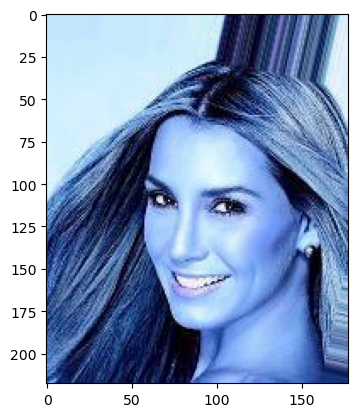

In [8]:
# Check image is it rgb or bgr

image = cv2.imread(sample_image_path[0])

plt.imshow(image)

#### Calculate mean and standard deivation of rgb channels of the dataset

In [9]:
def cal_mean_std(images_dir):
    """
    Calculates mean and standard deviation of images channel in a given directory using cv2 meanStdDev library. The mean and standard deviation are in BGR channel order

    Args:
        images_dir (string): Directory storing images to be referred to for channel mean/std calculation.

    Returns:
        mean_arr (numpy array): 2D numpy array representing the mean values in BGR channel
        std_dev_arr (numpy array): 2D numpy array representing the standard deviation of values in BGR channel
    Raises:
        IOError: File doesnt exist.
    """
    img_filenames = os.listdir(images_dir)
    mean_list, std_list = [], []

    for img_filename in img_filenames:
        try:
            img = cv2.imread(os.path.join(images_dir, img_filename))
            img = img / 255.0
            m, s = cv2.meanStdDev(img)

            mean_list.append(m.reshape((3,)))
            std_list.append(s.reshape((3,)))
        except:
            raise IOError
        
    mean_array = np.array(mean_list)
    std_array = np.array(std_list)
    mean_arr = mean_array.mean(axis=0, keepdims=True)
    std_dev_arr = std_array.mean(axis=0, keepdims=True)

    return mean_arr, std_dev_arr 

In [10]:
mean, std = cal_mean_std(WORKING_DATA_DIR)
print(mean, std)

# RGB mean and std for normalisation from dataset
stats = tuple(mean.squeeze(0)[::-1]), tuple(std.squeeze(0)[::-1])

[[0.38637948 0.43074377 0.51233411]] [[0.24095842 0.2449852  0.26584936]]


In [11]:
tuple(mean.squeeze(0)[::-1])

(0.5123341144332937, 0.43074376918895135, 0.3863794829116142)

Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

#### Define torch imagefolder (for transforms) and dataloader(prepare for data batches for model training)

In [12]:
image_transformer = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE), # Central square crop
    T.ToTensor(),
    T.Normalize(*stats)   # normalize => -1 to 1                               
])


train_ds = ImageFolder(
    root=os.path.dirname(WORKING_DATA_DIR), 
    transform=image_transformer
)

train_dl = DataLoader(
    train_ds, 
    BATCH_SIZE,
    shuffle=True,
    num_workers=3,# use some cores
    pin_memory=True # Speed up host to device transfer for training on gpu
) 


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.



In [13]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

# Helper function to show images

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])

  #In Pytorch -> C x Hx W whereas Matplotlib reques H x W x C. So, permute(1, 2, 0) do this.
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  return None
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

#### Show sample data batches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


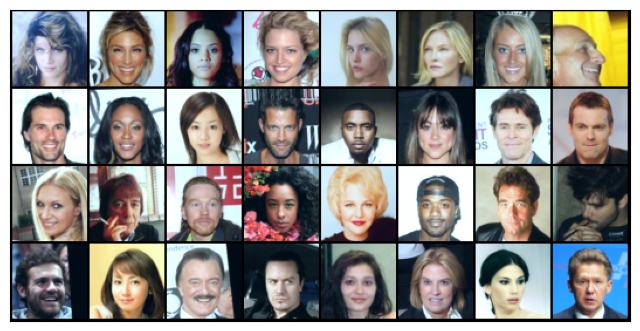

In [14]:
show_batch(train_dl, nmax=32)

Helper functions to load data onto cpu/gpu device based on detected hardware

In [15]:
def get_default_device():
    """Retrieves PC's cuda availability and returns the device to use

    Args:
      None

    Returns:
        Specific torch device to use (e.g torch.device(device name))

    Raises:
        None
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move all data types to provided device index
    
    Args:
        data (torch tensor): Data in torch tensor
        device (torch device): Device info/index for data loading

    Returns:
        Data loading to device input stated

    Raises:
        None
    
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device that is detected in batches.
    
    """
    def __init__(self, dl, device):
        """Constructor to instantiate dataloader and device attributes for the class.
    
        Args:
            dl (torch dataloader): Pytorch dataloader
            device (torch device): Device info/index for data loading

        Returns:
            None

        Raises:
            None
        
        """
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device
        
        Args:
            Mone

        Returns:
            None

        Raises:
            None
        
        """
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Return size of data batches in dataloader
        Args:
            Mone

        Returns:
            Size of data batchers in dataloader

        Raises:
            None
        
        """
        return len(self.dl)

In [16]:
# Check device
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

# Build GAN

## Discriminator Network/ Critic Network for case of WGAN

Define discriminator/critic network arcchitecture with Convolutional Layers as per DCGAN

In [18]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To decide if a generated image is fake/real based on real image
    nn.Sigmoid()
)

critic = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To output a value (like regression)
    nn.Linear(1,1)
)

Load discriminator/critic based on MODE value

In [19]:

if MODE == 'gan':
    discriminator = to_device(discriminator, device)
else:   
    discriminator = to_device(critic, device)

#### Lets print output shape after each layer of discrminator.

In [20]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Linear output shape: 	 torch.Size([1, 1])


# Generator Network

Transposed convolutional layers are the primary building blocks for the generator. (Kind of reverse process of convolution to restore original inputs to conv)
Through learning we can find the kernel that restores it.

(Ref: https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967)

Based on the journal article titled "The Effect of Latent Space Dimension on the
Quality of Synthesized Human Face Images" by Marin, Gotovac, Russo and Stulic, there are various latent dimensions used such as 100, 512, 64 or 128.

**Additional Notes**:
- Latent space has no meaning by itself but rather a hypersphere with each variable drawn from a Gaussian distribution of N(0,1)- an arbitrary distribution. It has structure when interpreted by generator model.

- Latent(hidden) basically can be attributed to the following ideas:

    - We map higher dimensional data to a lower dimensional data with no prior convictions of how the mapping will be done. The NN trains itself for the best configuration.
    - We cannot manipulate this lower dimensional data. Thus it is "hidden from us.
    - As we do not know what each dimension means, it is "hidden" from us.

It is related to Hidden Markov model concept. Think of seeing a shadow of humans behind a wall. I can only see


#### Define structure of generator for generating fake images
Ideally the generator layers are "reverse" of discriminator so as to generate images. This is done by keeping the kernel size, stride and padding the same as used in discriminator architecture, while reversing the layers.

In [21]:
generator = nn.Sequential(
    # input: latent vector of latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

#### Lets print output shape after each layer of generator.

In [22]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


#### Visualise generated images prior to training using a batch of latent sized vector sampled from random normal distribution 

torch.Size([128, 3, 64, 64])


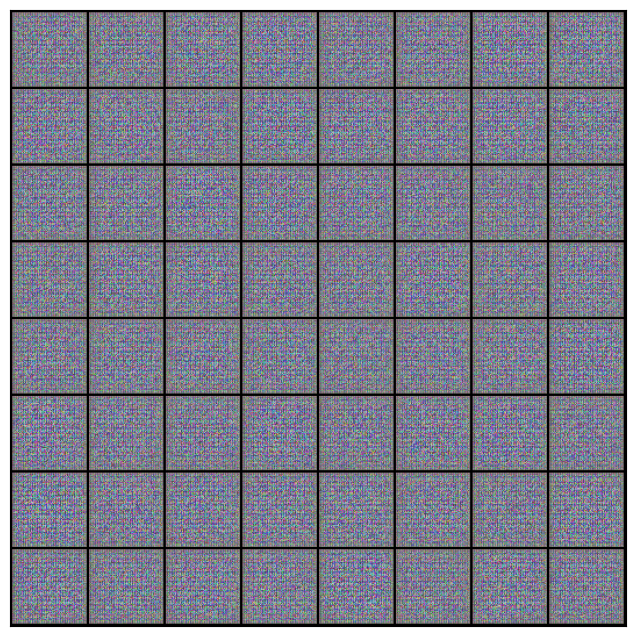

In [23]:
# Create a latent tensors of batch_size using  (* latent_size * 1 * 1) vector (N,C,H,W) with values normally distributed

xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images)


Move generator to device for subsequent training

In [24]:
generator = to_device(generator, device)

## Training Discriminator

Discriminator should accept 2 inputs: 1 actual image and 1 generated image

In [25]:
def train_discriminator(real_images,
                        opt_d,
                        discriminator_obj,
                        generator_obj,
                        batch_size=64,
                        latent_size=128,
                        mode='wgan'):
    """Function that constructs the process of discriminator training
    
    Args:
        real_images (torch tensor): 
            Data in torch tensor
        discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        batch_size (int): 
            Batch size of data for each pass. Defaults to 64.
        latent_size (int):
            Vector size of latent variable. Defaults to 128.
        opt_d (optimizer):
            Torch optimizer function
        mode (string): 
            GAN mode that affects the loss function used

    Returns:
        loss.item (torch): 
            Loss information by discriminator
        real_score (float):
            Measures how well it is able to discriminate  real image
        fake_score (float):
            Measures how well it is able to discriminate generated image
    Raises:
        NotImplementedError: For other mode types not belonging to gan/lsgan/wgan

    
    """
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Real image case: Pass real images through  discriminator and assign value 1 to indicate real
    real_preds = discriminator_obj(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    
    # Fake image case: Generate fake image using latent vector for a batch of data
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_obj(latent)

    # Pass Fake images through discriminator and declare them as 0 since we want discriminator to be 0
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator_obj(fake_images)

    if mode=='gan':
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        loss = real_loss + fake_loss
        # Combine loss and backward propagate
        loss.backward()
        opt_d.step()

    elif mode=='lsgan':
        # L2 loss function for discriminator involving (D(x) - b) and D(G(z))-a) where a is label for fake data and b is label for real data.

        mse_loss = torch.nn.MSELoss()
        real_loss = mse_loss(real_preds, real_targets)
        fake_loss = mse_loss(fake_preds, fake_targets)
        loss = 0.5 * (real_loss + fake_loss)

        loss.backward()
        opt_d.step()
    
    elif mode== 'wgan':
        # The discriminator doesnt really classify, but output a number (bigger for real than for fake) aka Critic loss. D(x) - D(G(z)). Since Discriminator needs to maximize this, it is equivalent to minimizing the negative of this.

        loss = -(real_preds.mean() - fake_preds.mean())
        
        loss.backward()
        opt_d.step()

        # Clip weights to be in a constrained value. This is to enforce the Lipschitz constraint on the critic’s model loss function
        c = C
        
        # Clamp values to constrained range
        for p in discriminator.parameters():
            p.data.clamp_(-c, c)
    else:
        raise NotImplementedError
    
    real_score = torch.mean(real_preds).item()

    fake_score = torch.mean(fake_preds).item()
    return loss.item(), real_score, fake_score



Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real Anime Faces dataset, and 0 if it was generated using the generator network.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.



It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [26]:
def train_generator(opt_g, 
                    discriminator_obj,
                    generator_obj,
                    batch_size=64,
                    latent_size=128,
                    mode = 'wgan'):
    """Function that implements the generator model process in generating image for discriminator to be fooled and calculates the losses obtained using discriminator response against supposedly real labels (response =1)

    Args:
        opt_g (optimizer):
            Torch optimizer for generator
        discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
        batch_size (int):
            Amount of batch data to be generated using stated latent_size vector. Defaults to 64
        latent_size (int):
            Vector size of latent variable. Default to 128.
        mode (string):
            GAN mode determining the loss function to use

    Returns:
        loss.item() (tensor contents): Contents of generator loss values

    Raises:
        NotImplementedError: When modes are not gan or lsgan or wgan
    
    """
    # Clear generator gradients before training
    opt_g.zero_grad()

    # Generate fake images of batch_size using latent_vector
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator_obj(latent)

    # Send image for discriminator response
    preds = discriminator_obj(fake_images)
    targets = torch.ones(batch_size, 1, device=device)

    if mode =='gan':
        loss = F.binary_cross_entropy(preds, targets)

    elif mode =='lsgan':
        # Similar to a-b decoding scheme in discriminator we now set label as 1 as we want generator to generate images that are as real as possible, hence -1
        mse_loss = torch.nn.MSELoss()
        loss = mse_loss(preds, targets)

    elif mode == 'wgan':
        # Evaluate mean of predictions for generated images
        loss = -preds.mean()
        
    else:
        raise NotImplementedError
    # Calculate loss based on response value and supposed 'real' target


    # Update generator 
    loss.backward()
    opt_g.step()

    return loss.item()

Create a directory to save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [27]:
os.makedirs(SAMPLE_DIR_GENERATED_IMAGE , exist_ok=True)

In [28]:
def save_samples(index, sample_dir, latent_tensors, generator_obj, show=True):
    """Function that saves generated image using provided latent tensors, while providing visualisation if show argument is True

    Args:
        index (int):
            Index for use in file name of image used for saving.
        sample_dir (string):
            Directory to store generated images.
        latent_tensors (torch tensor):
            Torch tensor representation of tensor to be used for generating fake images.
        generator_obj (Torch Sequential object):
            A defined sequence of neural network layers of generator object.
        show (bool): State to determine whether to plot generate images
    Returns:
        None
    Raises:
        None
    
    """
    # Create fake images
    fake_images = generator_obj(latent_tensors)

    # Filenamem for generated image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)

    # Plot out generated image using subplot
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    return None

## Training Loop

In [32]:
def fit(epochs, lr, batch_size, latent, sample_dir, discriminator_obj, generator_obj, mode='wgan'):
    """This functions implements the training process for generator and discriminator, with discriminator learning to identify real images before discriminating fake images
    
    Args:
      epochs (int): 
          Number of epochs for model training
      lr (float):
          Learning rate for gradient descent
      batch_size (int):
          Size of batches to be used for fitting 
      latent (torch tensor):
          Latent tensor for generating image
      sample_dir (string): 
          Directory which generated image would be save d
      discriminator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
      generator_obj (Torch Sequential object):
          A defined sequence of neural network layers for generator
      mode (string):
        GAN modes to determine the loss function for use

    Returns:
        losses_g (list): Measures losses of generator
        losses_d (list): Measures losses of discriminator
        real_scores (list): Measures the discriminator performance on identifying real images
        fake_scores (list): Measures how well it is able to discriminate generated image as fakes.
    Raises:
        None
    
    """
    # Empty any content in cuda 
    torch.cuda.empty_cache()

    # Losses & scores for generator and discriminator
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for discriminator
    opt_d = torch.optim.Adam(discriminator_obj.parameters(), 
                             lr=lr,
                             betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator_obj.parameters(),
                             lr=lr,
                             betas=(0.5, 0.999))

   
    # Loop through epoch and include losses and scores for both generator and discriminator. For LSGAN and DCGAN, updates are equal.
    # Clearing of gradients are done in train_discriminator and train_generator respectively.
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            
            # Train discriminator with specified optimizer. Becomes critic model for WGAN case which is updated more frequently than generator case 
            if mode != 'wgan':
                loss_d, real_score, fake_score = train_discriminator(\
                    real_images,
                    opt_d,
                    discriminator_obj, 
                    generator_obj,
                    batch_size,
                    latent.shape[1], 
                    mode
                )

            else:
                # Update critic(discriminator) for n_critic
                for _ in range(N_CRITIC):
                    loss_d, real_score, fake_score = train_discriminator(\
                        real_images,
                        opt_d,
                        discriminator_obj,
                        generator_obj, 
                        batch_size,
                        latent.shape[1], 
                        mode
                )

            # Train generator with specified optimizer
            loss_g = train_generator(
                opt_g,
                discriminator_obj,
                generator_obj, 
                batch_size,
                latent.shape[1],
                mode=mode
            )

        # Record losses & scores by epoch (after processing last batch of data in dataloader)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g for {}: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, mode, loss_g, loss_d, real_score, fake_score))

        # Save generated images based on GAN mode information
        save_samples(epoch+1, sample_dir, latent, generator_obj, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


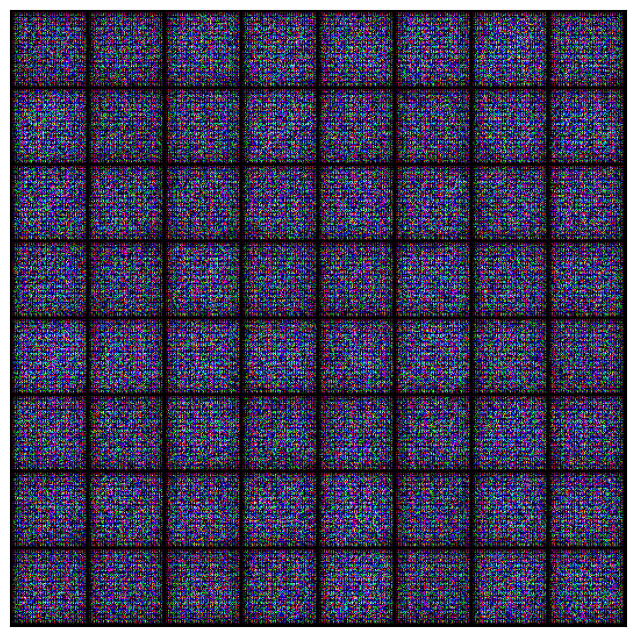

In [30]:
# Matrix of 64 datapoints represented by LATENT_SIZE,1,1 matrix
fix_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)
save_samples(0, SAMPLE_DIR_GENERATED_IMAGE, fix_latent, generator_obj= generator)

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.



In [33]:

history = fit(EPOCHS,
              LR,
              BATCH_SIZE,
              fix_latent,
              sample_dir=SAMPLE_DIR_GENERATED_IMAGE,
              discriminator_obj=discriminator, 
              generator_obj=generator,
              mode=MODE)

Epoch [1/60], loss_g for lsgan: 4.9473, loss_d: 0.1680, real_score: 0.8255, fake_score: 0.3674
Saving generated-images-0001.png
Epoch [2/60], loss_g for lsgan: 2.2714, loss_d: 0.1448, real_score: 0.7328, fake_score: 0.3047
Saving generated-images-0002.png
Epoch [3/60], loss_g for lsgan: 2.8822, loss_d: 0.1365, real_score: 0.9583, fake_score: 0.4425
Saving generated-images-0003.png
Epoch [4/60], loss_g for lsgan: 0.9570, loss_d: 0.5338, real_score: 0.6508, fake_score: -0.9556
Saving generated-images-0004.png
Epoch [5/60], loss_g for lsgan: 0.4667, loss_d: 0.1074, real_score: 0.9117, fake_score: -0.4134
Saving generated-images-0005.png
Epoch [6/60], loss_g for lsgan: 1.2201, loss_d: 0.0257, real_score: 0.8886, fake_score: -0.0986
Saving generated-images-0006.png
Epoch [7/60], loss_g for lsgan: 1.2943, loss_d: 0.0254, real_score: 1.0238, fake_score: 0.1405
Saving generated-images-0007.png
Epoch [8/60], loss_g for lsgan: 0.9047, loss_d: 1.3480, real_score: 0.3898, fake_score: -1.5177
Savin

In [34]:
# Save the model checkpoints of generator and discriminator

# Define state dict name
g_state_dict_name = 'G-{}.pth'.format(MODE)
d_state_dict_name = 'D-{}.pth'.format(MODE)
torch.save(generator.state_dict(), g_state_dict_name)
torch.save(discriminator.state_dict(), d_state_dict_name)

In [35]:
losses_g, losses_d, real_scores, fake_scores = history

Here's how the generated images look, after the 1st, and every 10th epochs of training.



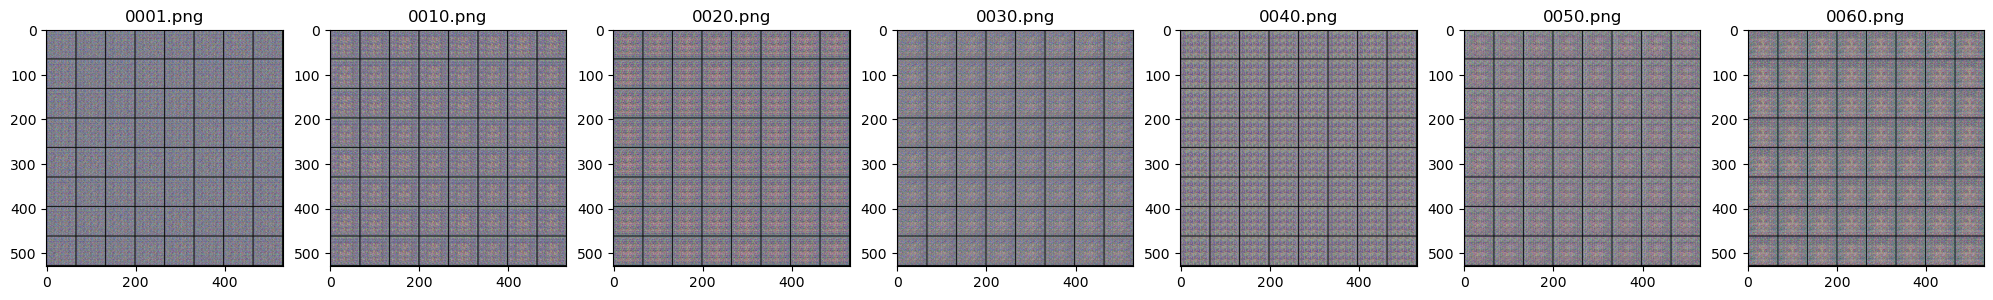

In [36]:
gen_image_id_list = ['0001', '0010', '0020', '0030', '0040', '0050', '0060']

relpath = os.path.join('generated', MODE, str(N_SAMPLES))
gen_image_path_list = [ os.path.join(os.getcwd(),
                                     relpath,
                                    'generated-images-{}.png'.format(id)) for id in gen_image_id_list]


fig, ax = plt.subplots(1, len(gen_image_id_list), figsize=(25,25))
for i, gen_image_path in enumerate(gen_image_path_list):
    img = plt.imread(gen_image_path)
    ax[i].imshow(img)
    ax[i].set(title = str(gen_image_id_list[i]) +'.png')


We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.



In [37]:
# Define video filename and filepath
vid_fname = 'gans-training-{}-sample-{}.avi'.format(MODE, N_SAMPLES)
vid_fpath = os.path.join(SAMPLE_DIR_GENERATED_IMAGE, vid_fname)

print("Starting converting images to video.")
files = [os.path.join(SAMPLE_DIR_GENERATED_IMAGE, f) for f in os.listdir(SAMPLE_DIR_GENERATED_IMAGE) if 'generated' in f]
files.sort()

print(files)



fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fpath, fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

Starting converting images to video.
['c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0000.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0001.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0002.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0003.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0004.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0005.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0006.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0007.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-images-0008.png', 'c:\\Users\\Admin\\Desktop\\GAN_sharing_AIAP\\generated\\lsgan\\1000\\generated-

Here's what it looks like:



We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

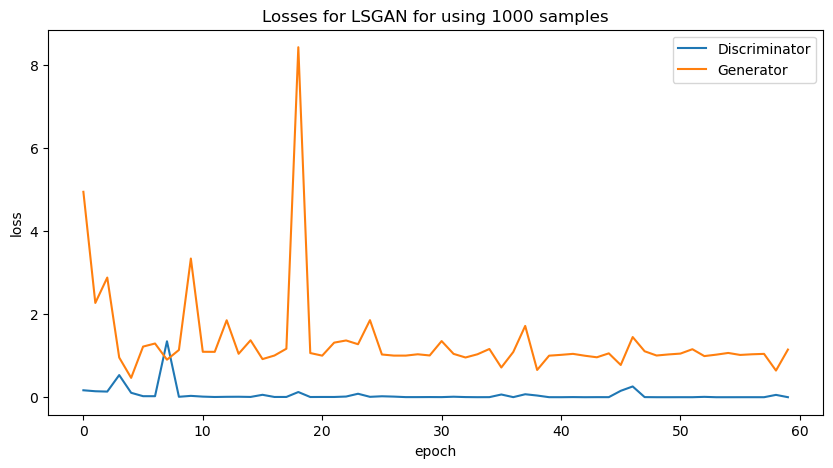

In [38]:
plt.figure(figsize=(10,5))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'], loc='best')
plt.title('Losses for {} for using {} samples'.format(MODE.upper(), N_SAMPLES));

loss_plot_fname = 'loss-{}-sample-{}.png'.format(MODE, N_SAMPLES)
plt.savefig(loss_plot_fname)

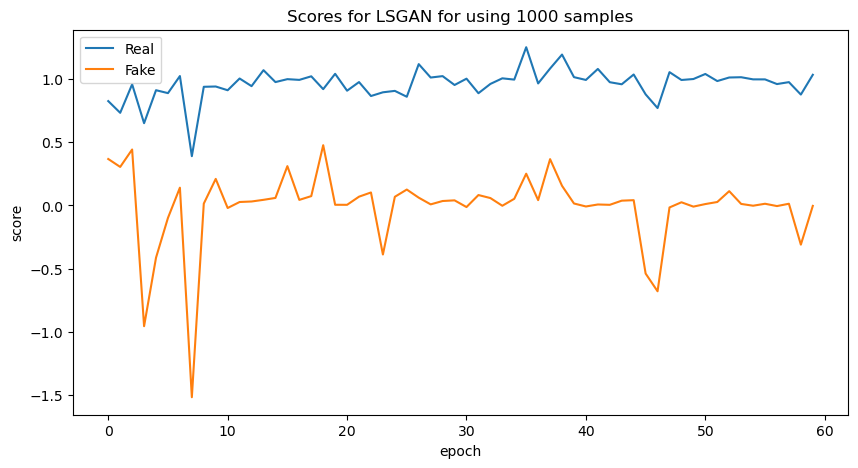

In [39]:
plt.figure(figsize=(10,5))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'], loc='best')
plt.title('Scores for {} for using {} samples'.format(MODE.upper(), N_SAMPLES));

score_plot_fname = 'score-{}-sample-{}.png'.format(MODE, N_SAMPLES)
plt.savefig(score_plot_fname)